# Exploratory analysis

In this notebook, we explore the movie distribution in our dataset, with respect to **time** and our main features, which are **average ratings**, **budget** and **revenue**. We try to understand how they are distributed and how they relate to each other, in a robust manner using vizualisation and statistics, to already draw general conclusions to address our question. We also show that correction for inflation is key to prevent false conclusions.

## Table of contents 
- [0) General overview](#0-general-overview)
- [1) Rating, Revenue and Budget](#1-rating-revenue-and-budget)
    - [1.1) An overview of the distributions](#11-an-overview-of-the-distributions)
    - [1.2) Effect of inflation](#12-effect-of-inflation)
    - [1.3) Rating, revenue and budget across time](#13-rating-revenue-and-budget-across-time)
    - [1.4) Relationships between rating, revenue and budget](#14-relationships-between-rating-revenue-and-budget)
    - [1.5) Conclusion](#15-conclusion)

A lot of functions used here can be found in the [helpers.py](helpers.py)

Imports:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from scipy import stats
from scipy.stats import pearsonr
from helpers import *

style.use('tableau-colorblind10')

%load_ext autoreload
%autoreload 2

## 0) General overview

Let's load and visualize our dataset

In [2]:
df_movie = pd.read_csv("data/Expanded_data/big_data_final.tsv",sep='\t',low_memory=False)
print(df_movie.shape)
df_movie.head()

(649700, 13)


,Freebase movie ID,IMDB_id,Movie box office revenue,Movie genres names,Movie name,Movie release date,averageRating,budget,numVotes,prod_country,inflation coeff,inflation corrected revenue,inflation corrected budget
0,/m/0100_m55,tt0138297,NaN,"['Comedy', 'Sci-Fi']",Urban Animals,1987.0,5.2,NaN,79.0,NaN,2.384772,NaN,NaN
1,/m/0100_mnm,tt0202813,NaN,['Comedy'],NaN,1999.0,5.8,NaN,15.0,NaN,1.626713,NaN,NaN
2,/m/0100_nzr,tt0184302,NaN,['Drama'],NaN,1999.0,4.8,NaN,119.0,NaN,1.626713,NaN,NaN
3,/m/0100_pgp,tt0094831,NaN,['Comedy'],NaN,1988.0,6.8,NaN,103.0,NaN,2.291337,NaN,NaN
4,/m/0100_pz9,tt0088884,NaN,['Comedy'],NaN,1985.0,2.4,NaN,59.0,NaN,2.519087,NaN,NaN


#### Dataset description

- `Freebase movie ID`: official freebase id of the movie.
- `IMDB_id`: official IMDB id of the movie.
- `Movie box office revenue`: in US dollar at time of movie releasing.
- `Movie genres names`: list of genres of the movie.
- `Movie name`: official english name of the movie.
- `Movie release date`: year of movie releasing.
- `averageRating`: average rating of the movie [0,10], where 10 is the best and 0 is the worst.
- `budget`: in US dollar at time of movie production.
- `numVotes`: number of people who gave a rating on the movie.
- `prod_country`: contry of movie production.
- `inflation coeff`: coefficient by which money values must be multiply to be consistent with the year 2021.
- `inflation corrected revenue`: revenue corrected taking into account the inflation.
- `inflation corrected budget`: budget corrected taking into account the inflation.

In order to give an idea of how many movies are present per year, we can look at the distribution across the time.

### Year distribution

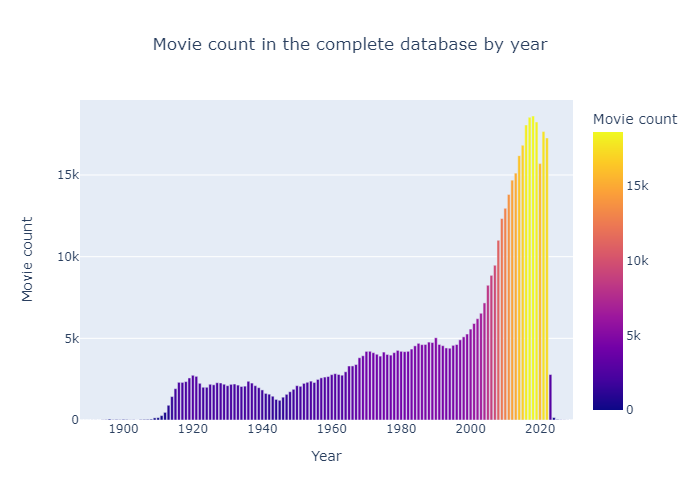

In [3]:
year_distribution(df_movie, 'Movie count in the complete database by year', 'year_movie_distr', True)

We remark that the dataset is not realistic when we approach 2020. We should be careful if we want to draw conclusion from those specific years.
As we would expect, we see that there is an exponential growth which starts around 1990.

Since we are going to focus on the average rating as marker of a good movie, it is wise to look at the number of rating across the years.

In [4]:
df = df_movie.dropna(subset=['numVotes','Movie release date'])
years = np.sort(df['Movie release date'].unique())
votes = np.zeros(len(years))

for i,y in enumerate(years):
    votes[i] = np.sum(df.loc[df['Movie release date']==y].numVotes)

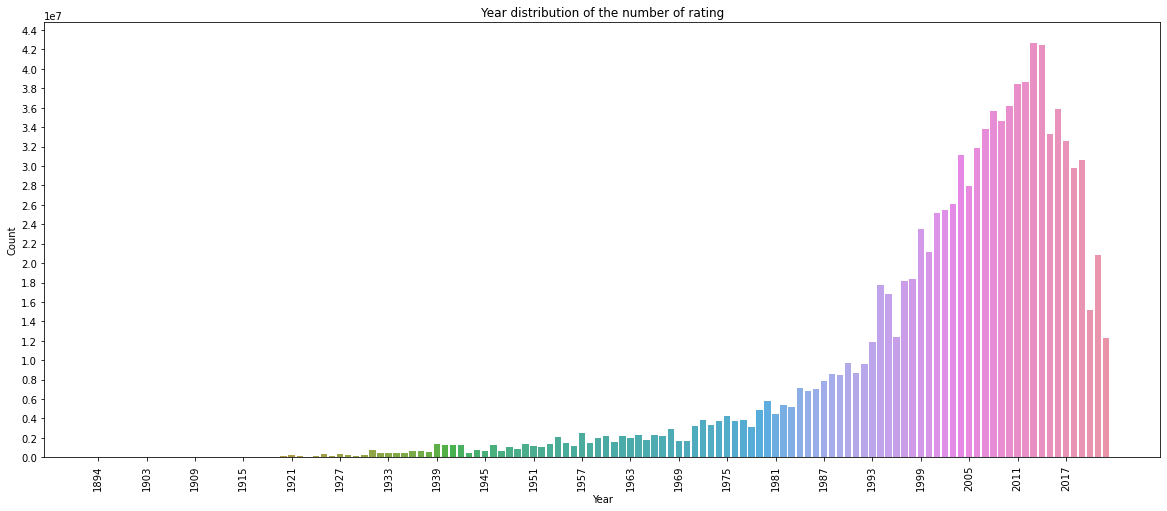

In [5]:
plt.figure(figsize=(20,8))
sns.barplot(x=years.astype('int64'), y=votes).set(title='Year distribution of the number of rating')
plt.xticks(rotation='vertical')
plt.locator_params(nbins=25)
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

As we can see from the plot below, it seems that the number of ratings roughly follows the number of movies.

## 1) Rating, Revenue and Budget
To determine the success of a movie, we want to consider the box office revenue, the budget and the rating. Therefore, we have to analyse the relationship between these features. First of all we are going to focus on their distributions and the evolution across time. Then, we are going to compute the correlation coefficients between the variables.

The budgets and the revenues are corrected by considering the inflation. Thanks to this step we can compare revenues and budgets across years.

For each year there are several movies and therefore several ratings, revenues and budgets. We decided to average these variables for each year in order to get one single data point for each time point. But the mean hides a dark side, its sensitivity to outliers. This is why we are also going to compute the median values for each of the variable of interest. At the end of our analysis we are also going to consider the datapoints without doing mean/median for a more fine-grain view.

For all the test statistics we are going to use 5% as signifiant threshold. We will use *RRB* as abbreviation for *rating, revenue and budget*.

### 1.1) An overview of the distributions

The inflation data start at 1959, therefore we are going to remove several movies.

In [6]:
dist = df_movie.dropna(subset=['inflation corrected budget','inflation corrected revenue','averageRating'])

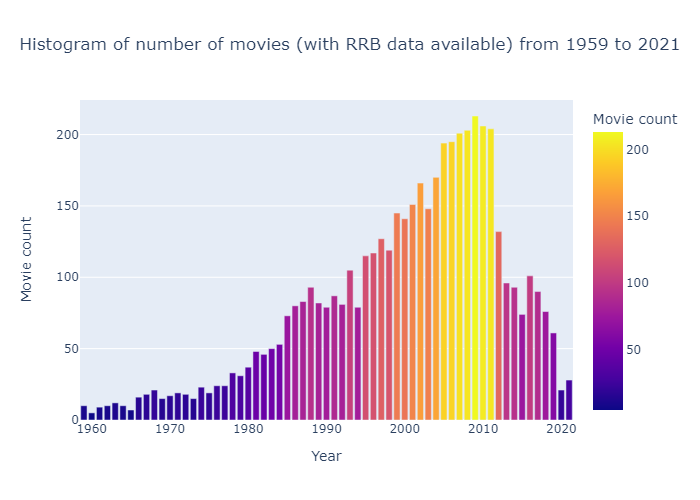

In [7]:
year_distribution(dist, 'Histogram of number of movies (with RRB data available) from 1959 to 2021')

The distribution above corresponds to the movie dataset that we are going to use across all the section 1.

Below we display the distributions of revenue, rating and budget (USD$ corrected with inflation).

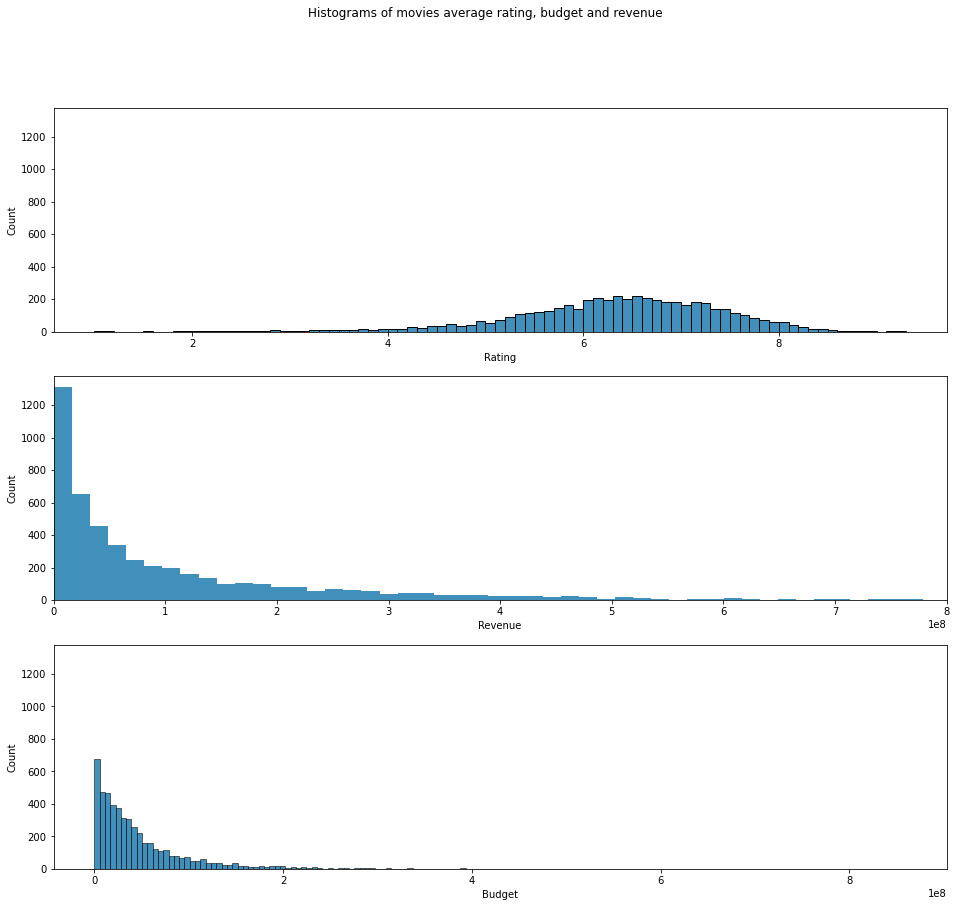

In [8]:
# linear scale
plot_RRB_distr(dist, title='Histograms of movies average rating, budget and revenue')


For the revenue we had to set boundaries to the x axis otherwise we would not have seen anything because of some huge outliers.
As budget and revenue are heavy-tailed, therefore it is wise to use a log representation.

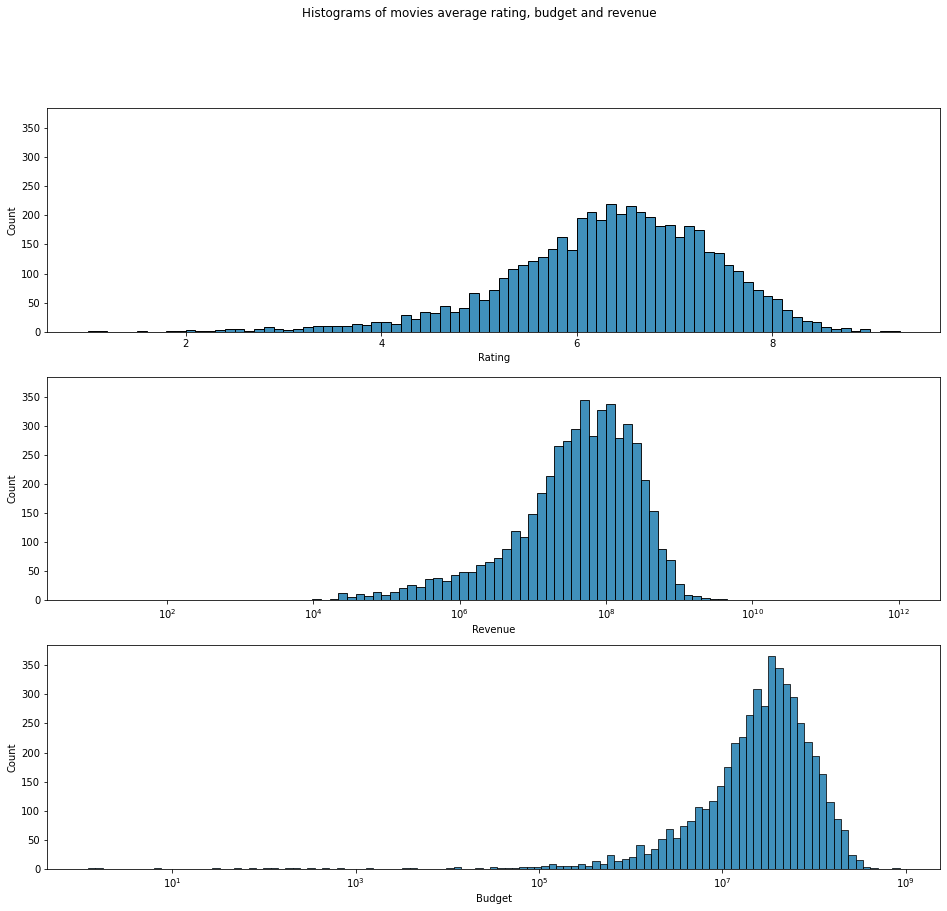

In [9]:
# log scale for revenue and bugdet 
plot_RRB_distr(dist, log = [True, False], xlim = False,
title = 'Histograms of movies average rating, budget and revenue',
filename = 'hist_RRB_log', save = True)

The ratings lay within the range 0-10. The log representation of the revenue and budget shows us that both of the variables are highly present around $10^8$ US dollar. If we keep these variables under this form, we can safely assume they are gaussian distributions.

### 1.2) Effect of inflation

In the previous section and the rest of the analysis, we corrected USD$ for inflation. In this subsection we are going to demonstrate why this matters.

In [10]:
budget = df_movie.dropna(subset=['budget', 'inflation corrected budget'])

Let's compute the mean and median for corrected and uncorrected budget and plot them.

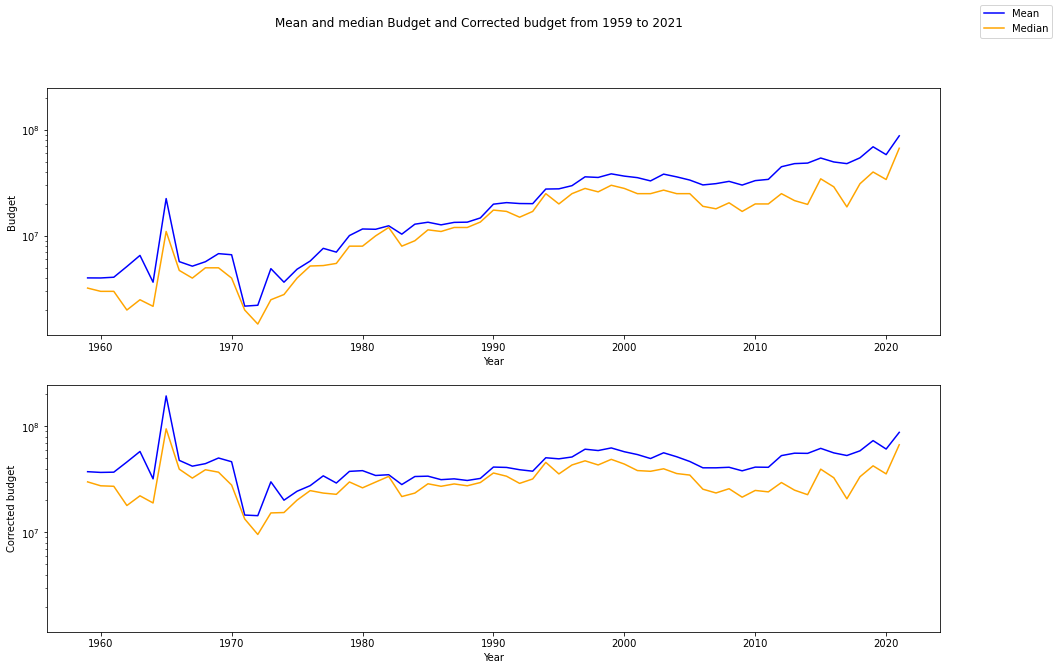

In [11]:
output = mean_median(budget, ['budget', 'inflation corrected budget'])
plot_mean_median(output, ylabel = ['Budget', 'Corrected budget'], filename = 'mean_median_budget_corrected', save = True)

For the case of the budget, we see that without the correction there is a quite constant increasing from 1959 to 2021, even if there is an high variability. We remark that with the correction, we do not observe an increase.

There is higher variability during the first years (1959-1973), which are probably due to the low number of movies during these years (around 10 for each year in our RRB-reduced dataset).

The same reasoning can be applied to the revenue, as demonstrated in the plots below.

In [12]:
revenue = df_movie.dropna(subset=['Movie box office revenue', 'inflation corrected revenue'])

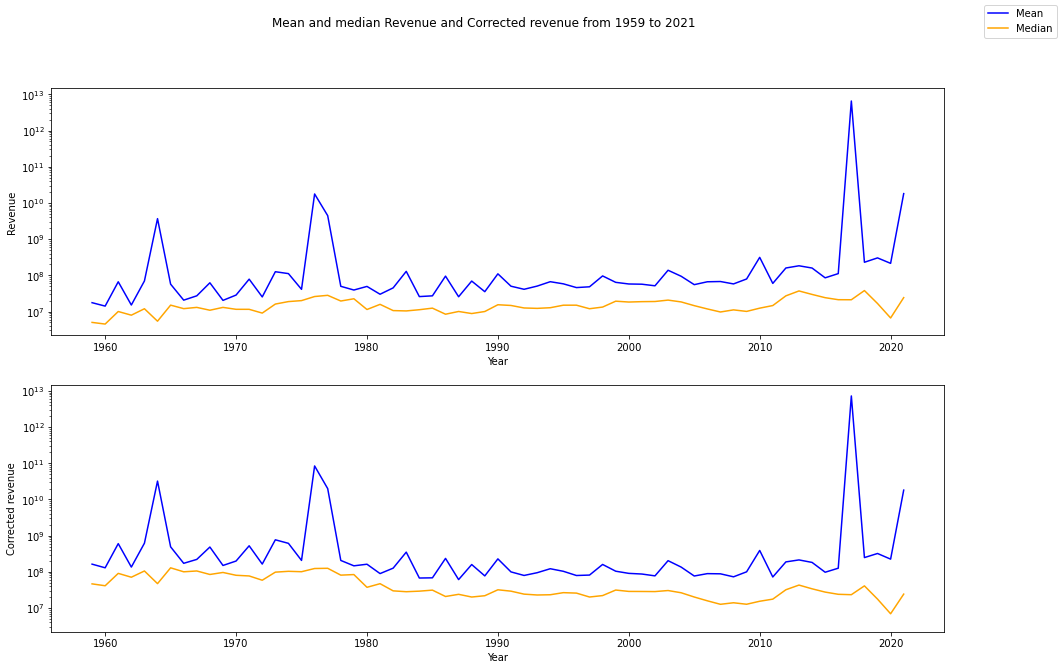

In [13]:
output = mean_median(revenue, ['Movie box office revenue', 'inflation corrected revenue'])
plot_mean_median(output, ylabel = ['Revenue', 'Corrected revenue'], filename = 'mean_median_revenue_corrected', save = True)

For both parameters, we see that the median value is below the mean value. It is most likely explained by the fact as we saw earlier, these distributions are heavy tailed, with few high revenues and budgets, which drives the arithmetic mean upwards. The median is more representative of the data here.

### 1.3) Rating, revenue and budget across time

In this part we are going to consider the evolution of the corrected RRB variables across time. For this we display the mean and the median along with their confidence intervals.

Let's gather these values and plot them.

In [14]:
df = df_movie.dropna(subset=['inflation corrected revenue', 'averageRating','inflation corrected budget'])
years = np.sort(df['Movie release date'].unique())

mean, median, low, high, low_median, high_median = np.zeros((3, len(years))), np.zeros((3, len(years))), np.zeros((3, len(years))), np.zeros((3, len(years))), np.zeros((3, len(years))), np.zeros((3, len(years)))

for i,y in enumerate(years):
    
    mean[0, i], median[0, i], low[0, i], high[0, i], low_median[0, i], high_median[0, i] = bootstrap(df.loc[df['Movie release date'] == y]['inflation corrected revenue'],1000, True)
    mean[1, i], median[1, i], low[1, i], high[1, i], low_median[1, i], high_median[1, i] = bootstrap(df.loc[df['Movie release date'] == y]['inflation corrected budget'],1000, True)
    mean[2, i], median[2, i], low[2, i], high[2, i], low_median[2, i], high_median[2, i] = bootstrap(df.loc[df['Movie release date'] == y]['averageRating'],1000, True)
    

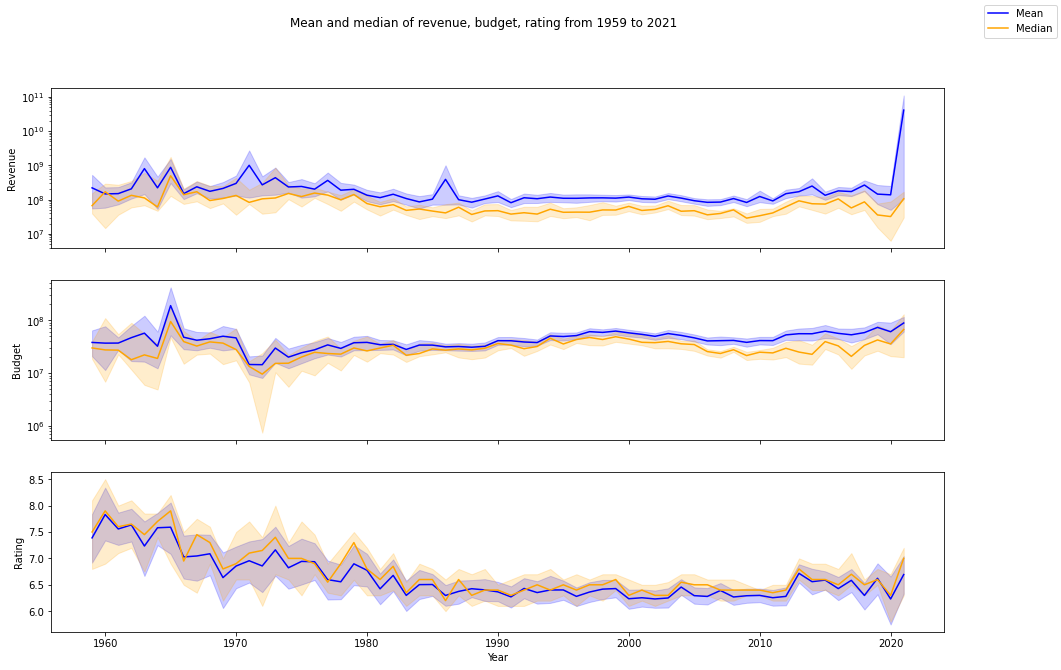

In [15]:
plot_RRB_across_time(years, mean, median, low, high, low_median, high_median,
                    filename = 'RRB_across_time', save = True)

We remark again that the median is lower that the mean for the revenue and the budget. In the case of the rating we do not see such a behaviour, because it is distributed as a gaussian.

Most notably, budget and revenue seem to remain fairly constant throughout the whole time period, while ratings dropped from 1 points over 10. The reasons for this can be many. For example, the quality of movies might really have dropped due to the commercialisation of cinema,or the growing offer (as seens in the number of movies histogram earlier) and the better accessibility to the movies might have made the public pickier. We cannot conclude on any of those we the data at our disposal.

In any case, it seems that creating a movie well graded by the public is harder now than is was before !

### 1.4) Relationships between rating, revenue and budget

Here, we are going to investigate how these RRB features are related to each other using simple correlation.

Let's beat the data into shape.

In [16]:
df_pair = pd.DataFrame(columns=['Log revenue','Log budget','Rating','Type'])
df_pair['Log revenue'] = np.log(np.concatenate((mean[0],median[0])))
df_pair['Log budget'] = np.log(np.concatenate((mean[1],median[1])))
df_pair.Rating = np.concatenate((mean[2],median[2]))


type_mean = np.empty(len(years), dtype='object')
type_mean.fill('Mean')
type_median = np.empty(len(years), dtype='object')
type_median.fill('Median')

df_pair.Type = np.concatenate((type_mean,type_median))

In [17]:
df_pair.head()

,Log revenue,Log budget,Rating,Type
0,19.214526,17.454539,7.388500,Mean
1,18.806169,17.423866,7.830320,Mean
2,18.826777,17.426823,7.557556,Mean
3,19.147122,17.662518,7.634160,Mean
4,20.508115,17.858603,7.234233,Mean


Let's plot mean and median (by year), regressor curve and density for all RRB pairs to have a general overview of the situation.

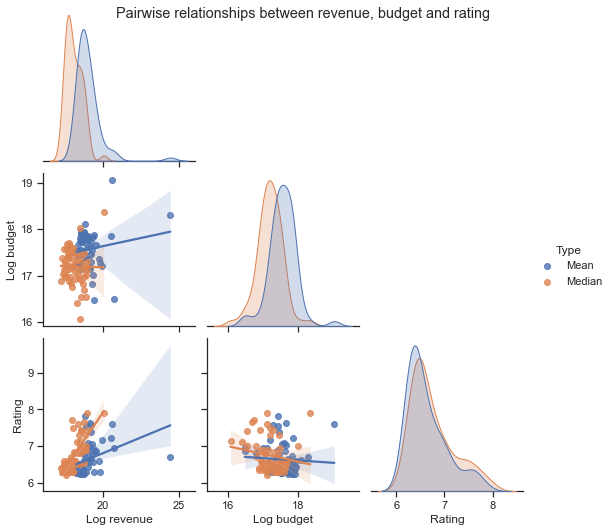

In [18]:
sns.set_theme(style="ticks")
rel = sns.pairplot(df_pair, hue="Type",kind='reg',corner=True)
rel.fig.suptitle('Pairwise relationships between revenue, budget and rating')
plt.show()

As we expect from previous analysis, the median and the mean distributions of revenue and budget are different, while they heavily overlap for ratings.

Now we are going to consider the median only, as we established it is a more representative measure.

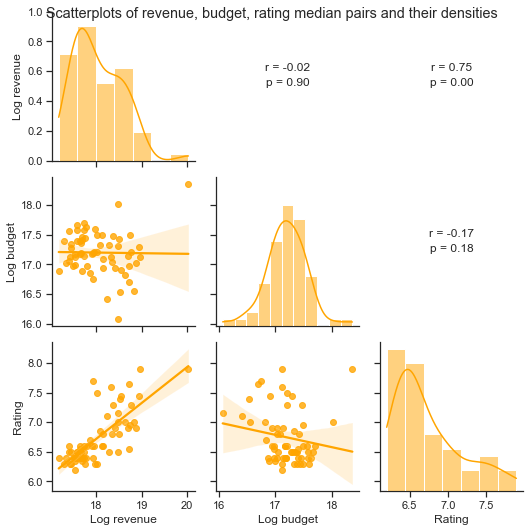

In [19]:
# scattering(df_pair, 'Scatterplots of revenue, budget, rating mean pairs and their densities', 'Mean', 'blue')
scattering(df_pair, 'Scatterplots of revenue, budget, rating median pairs and their densities', 'Median', 'orange')

If we look at the scatter plot matrices of the medians, we see that the only significant result is the one between the log revenue and rating, with a correlation coefficient of about 0.75. It seems that the two are strongly correlated, meaning years during which good movies are produced tend to be successful years in terms of cinema revenue as well.

If we look to the pearson coefficients with more digits, the significance is even more striking:

In [20]:
print(f'Pearson correlation between:')
print(f'\t the log median of revenue and the median of rating: {stats.pearsonr(np.log(median[0]),median[2])}\n')
print(f'\t the log median of revenue and the log median of budget: {stats.pearsonr(np.log(median[0]),np.log(median[1]))}\n')
print(f'\t the median of rating and the log median of budget: {stats.pearsonr(median[2],np.log(median[1]))}')

Pearson correlation between:
	 the log median of revenue and the median of rating: (0.7478671956762926, 1.8818997333351005e-12)

	 the log median of revenue and the log median of budget: (-0.01610023646249227, 0.9003329841669626)

	 the median of rating and the log median of budget: (-0.1722077464363259, 0.1771467866183326)


The significance stands beyond multiple testing correction.

### 1.5) Relationships between rating, revenue and budget using datapoints (not median)

It is necessary to look at all the values without averaging for each year to have a fine-grain view of the situation at the movie level. Here, we generate a similar plot as in the last section, with the datapoints and not the median.

In [25]:
alldata = df[['inflation corrected revenue','inflation corrected budget','averageRating']].copy()
alldata['inflation corrected revenue'] = alldata['inflation corrected revenue'].apply(np.log)
alldata['inflation corrected budget'] = alldata['inflation corrected budget'].apply(np.log)
alldata = alldata.rename(columns={'inflation corrected revenue':'Log revenue','inflation corrected budget':'Log budget','averageRating':'Rating'})

In [26]:
alldata.head(2)

,Log revenue,Log budget,Rating
33,15.361558,15.336866,7.6
225,19.411946,18.123773,7.0


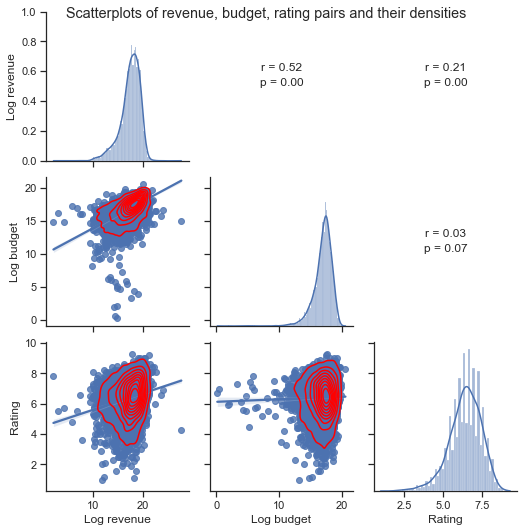

In [27]:
scattering(alldata, 'Scatterplots of revenue, budget, rating pairs and their densities', 'All data', add_kde = True, filename = 'pairgrid_RRB_by_point', save = True)

We observe that there is a significant correlation between rating and log of revenue, as before, but this time we also have a significant relationship between log revenue and log budget. Well graded movies tend to generate money, and the higher the budget the higher the revenue to some extent (the correlation coefficient is still low).

More details on exact digits are provided by the following cell: 

In [29]:
print('Pearson correlation between:')
print(f"\t log of revenue and rating: \
    {stats.pearsonr(np.log(df['inflation corrected revenue']),df['averageRating'])}")
print(f"\t log of revenue and log of budget: \
    {stats.pearsonr(np.log(df['inflation corrected revenue']),np.log(df['inflation corrected budget']))}")
print(f"\t rating and log of budget: {stats.pearsonr(df['averageRating'],np.log(df['inflation corrected budget']))}")

Pearson correlation between:
	 log of revenue and rating:     (0.21004631856167072, 3.715458166493649e-51)
	 log of revenue and log of budget:     (0.5237159320577686, 0.0)
	 rating and log of budget: (0.02518609405449282, 0.0744001234578339)


Both significant results remain significant beyond any multiple testing correction.

### 1.5 Conclusion

 Here's what we learn from this first analysis:
 * The number of movies and ratings are increasing in an exponential fashion from 1990-2000 an on.
 * Revenue and budget are heavy-tailed, but their log is gaussian, as are distributed the ratings. Inflation is important to correct USD$ to comparable values through years
 * Median (and mean) ratings are going down of 10% of the maximum grade between 1960 and 2000 for potentially multiple reasons.
 * Good movies tend to generate money (medium correlation), and the higher the budget the higher the revenue (small correlation)

With respect to our question, creating a good movie (in terms of pure grade) might be harder now than it was before. If our movie is good, it is likely to generate more revenue. Our low budget is definitely a disadvantage, but the magnitude of the effect is low, and we should be able to overcome it !

Now, what parameters influence these grades and revenue ? Does revenue generate good grade, the contrary, or a cofounder ?
We choose as measure for the success of the movie : the average rating and the $\frac{revenue}{budget}$ which can reflect the financial yield.

### Go to [Genre.ipynb](Genre.ipynb) to continue the analysis.